In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
import scipy.io as sio
import os

base_path =  '/data/big_rim/rsync_dcc_sum/25Apri_social/2025_05_02/1shank3KOM_boxedshank3KOF' #'/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/20240910v1r_cricket_cyliner_test_16_17' #'/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_BO_11_35' #'/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/20240910v1r_cricket_cyliner_test_16_17'
pred_folder = 'DANNCE/predict00'
# label3d_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_06_28/1686941_left_right_2/pos_synced_1686941_left_right_2_2024_06_28_1686941_left_label3d_dannce.mat' #calib
pred_path = os.path.join(base_path, pred_folder, 'save_data_AVG.mat') #  smoothed_prediction_AVG0.mat

pred_3d = sio.loadmat(pred_path)['pred']
pred      = np.squeeze(pred_3d, axis=1)

com_file = os.path.join(base_path,pred_folder,'com3d_used.mat')
com_data = sio.loadmat(com_file)['com']

print(f"com_data {com_data.shape},  pred {pred.shape}")

com_data (13798, 3),  pred (13000, 3, 22)


In [31]:
x, y = com_data[:,0], com_data[:,1]
pts  = np.stack([x,y], axis=1)
hull = ConvexHull(pts)
hx, hy = pts[hull.vertices,0], pts[hull.vertices,1]


def residuals(p, xx, yy):
    xc,yc,r = p
    return np.sqrt((xx-xc)**2 + (yy-yc)**2) - r

init = [hx.mean(), hy.mean(), np.mean(np.hypot(hx-hx.mean(), hy-hy.mean()))]
res  = least_squares(residuals, init, args=(hx, hy))
xc, yc, r = res.x

print(f"Circle → center=({xc:.1f},{yc:.1f}),  radius={r:.1f} mm")


keypoint_labels = [
    'EarL','EarR','Snout','SpineF','SpineM','Tail(base)','Tail(mid)','Tail(end)',
    'ForepawL','WristL','ElbowL','ShoulderL','ForepawR','WristR','ElbowR','ShoulderR',
    'HindpawL','AnkleL','KneeL','HindpawR','AnkleR','KneeR'
]
paw_labels = ['HindpawL','HindpawR']
paw_idxs   = [keypoint_labels.index(lbl) for lbl in paw_labels]
# paw_labels = ['Tail(base)']
# paw_idxs   = [keypoint_labels.index('Tail(base)')]
print(paw_idxs)
# paw_idxs = [15,18]

threshold = 5.0  # mm above each paw’s minimum Z
candidate_pts = []
for idx in paw_idxs:
    coords = pred[:,:,idx]   # (F,3)
    xs, ys, zs = coords[:,0], coords[:,1], coords[:,2]
    sel = zs <= zs.min() + threshold
    candidate_pts.append(np.stack([xs[sel], ys[sel], zs[sel]], axis=1))
candidate_pts = np.vstack(candidate_pts)
print("Candidate contact pts:", candidate_pts.shape)

# SVD plane fit
centroid = candidate_pts.mean(axis=0)
_,_,Vt = np.linalg.svd(candidate_pts - centroid)
normal = Vt[-1]
if normal[2] < 0:
    normal = -normal

# table Z at (xc,yc)
table_z = centroid[2] - (normal[0]*(xc-centroid[0]) + normal[1]*(yc-centroid[1])) / normal[2]
tilt_rad = np.arccos(np.clip(normal.dot([0,0,1]), -1, 1))
tilt_deg = np.degrees(tilt_rad)
print(f"Table Z @ center = {table_z:.2f} mm,  tilt = {tilt_deg:.2f}°")


Circle → center=(-36.2,26.6),  radius=521.6 mm
[16, 19]
Candidate contact pts: (468, 3)
Table Z @ center = -10.41 mm,  tilt = 0.40°


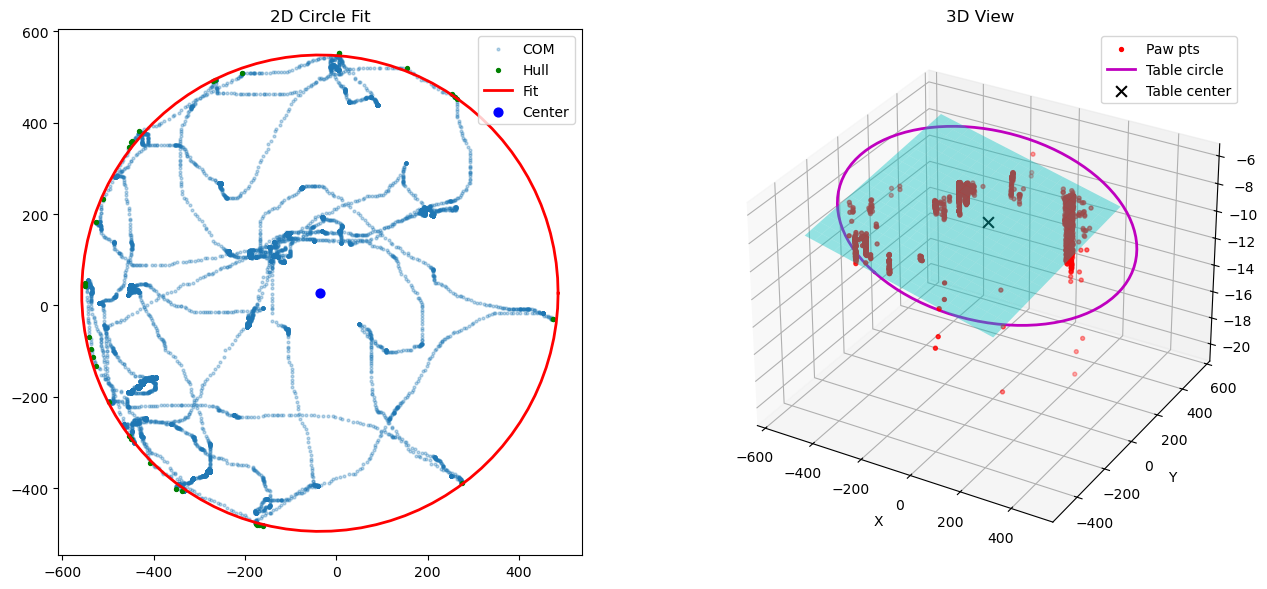

In [34]:
# ─── Cell 2: PLOT 2D + 3D ───────────────────────────────────────────────
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# reuse everything from Cell 1: x,y,hx,hy,xc,yc,r,candidate_pts,centroid,normal

theta = np.linspace(0, 2*np.pi, 100)

# basis for table plane
def plane_basis(n):
    v = np.array([1,0,0]) if abs(n[:2]).sum()<1e-6 else np.array([0,0,1])
    b1 = np.cross(n, v);  b1 /= np.linalg.norm(b1)
    b2 = np.cross(n, b1); b2 /= np.linalg.norm(b2)
    return b1, b2

b1, b2 = plane_basis(normal)
table_center = np.array([xc, yc, table_z])
circle3d = np.array([table_center + r*(np.cos(t)*b1 + np.sin(t)*b2) for t in theta])

fig = plt.figure(figsize=(14,6))

# 2D
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(x, y,     s=4, alpha=0.3, label='COM')
ax1.scatter(hx, hy,   s=8, color='g', label='Hull')
ax1.plot(xc + r*np.cos(theta), yc + r*np.sin(theta), 'r-', lw=2, label='Fit')
ax1.scatter(xc, yc,   color='b', s=40, label='Center')
ax1.set_aspect('equal'); ax1.set_title('2D Circle Fit'); ax1.legend()

# 3D
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.scatter(*candidate_pts.T, color='r', s=8, label='Paw pts')
# plot plane
grid_x = np.linspace(candidate_pts[:,0].min(), candidate_pts[:,0].max(), 20)
grid_y = np.linspace(candidate_pts[:,1].min(), candidate_pts[:,1].max(), 20)
gx, gy = np.meshgrid(grid_x, grid_y)
gz = centroid[2] - (normal[0]*(gx-centroid[0]) + normal[1]*(gy-centroid[1]))/normal[2]
ax2.plot_surface(gx, gy, gz, alpha=0.4, color='cyan')
# plot circle in plane
ax2.plot(circle3d[:,0], circle3d[:,1], circle3d[:,2], 'm-', lw=2, label='Table circle')
ax2.scatter(*table_center, color='k', s=60, marker='x', label='Table center')
ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z'); ax2.set_title('3D View')
ax2.legend()

plt.tight_layout()
plt.show()


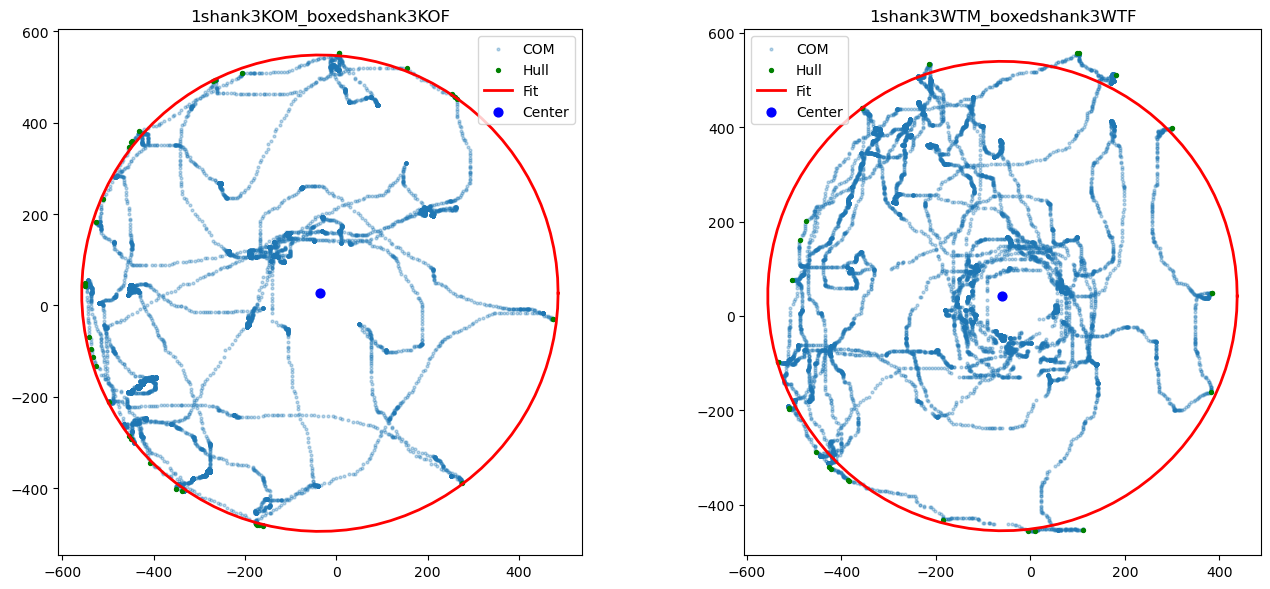

In [40]:
# ─── Cell 2 (revised): TWO 2D SUBPLOTS ───────────────────────────────────────────────

new_base_path = '/data/big_rim/rsync_dcc_sum/25Apri_social/2025_05_02/1shank3WTM_boxedshank3WTF'  # ← set this to the second folder you want to compare

paths  = [base_path, new_base_path]
titles = ['1shank3KOM_boxedshank3KOF', '1shank3WTM_boxedshank3WTF']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
theta = np.linspace(0, 2*np.pi, 100)

for ax, pth, title in zip(axes, paths, titles):
    # load COM data
    com_file = os.path.join(pth, pred_folder, 'com3d_used.mat')
    com_data = sio.loadmat(com_file)['com']
    x, y = com_data[:,0], com_data[:,1]
    
    # hull & circle fit
    pts  = np.stack([x, y], axis=1)
    hull = ConvexHull(pts)
    hx, hy = pts[hull.vertices,0], pts[hull.vertices,1]
    init = [hx.mean(), hy.mean(), np.mean(np.hypot(hx-hx.mean(), hy-hy.mean()))]
    res  = least_squares(residuals, init, args=(hx, hy))
    xc, yc, r = res.x
    
    # plot
    ax.scatter(x, y,     s=4, alpha=0.3, label='COM')
    ax.scatter(hx, hy,   s=8, color='g',      label='Hull')
    ax.plot(xc + r*np.cos(theta), yc + r*np.sin(theta),
            'r-', lw=2,                     label='Fit')
    ax.scatter(xc, yc,   color='b', s=40,     label='Center')
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()


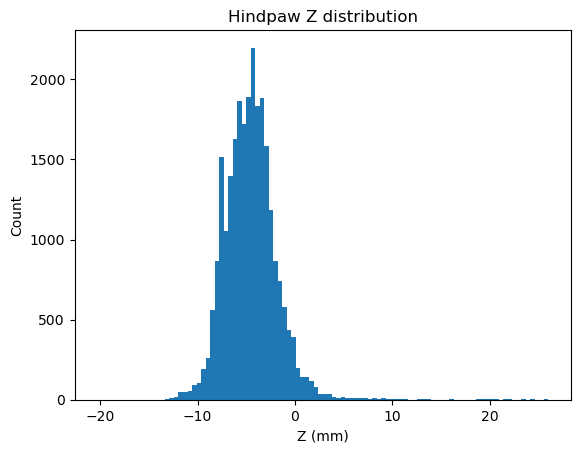

5th percentile z = -8.31 mm → using threshold = -7.31 mm
Selected candidate contact pts: (3838, 3)
Table Z @ center = -8.63 mm,  tilt = 0.27°


In [35]:
import matplotlib.pyplot as plt

#--- combine both hindpaws into one big list -------------------------
hp_idxs = [16, 19]   # HindpawL, HindpawR
all_hps = np.vstack([pred[:, :, i] for i in hp_idxs])  # shape (2F,3)

zs = all_hps[:, 2]
# 1) quick histogram to eyeball noise
plt.hist(zs, bins=100)
plt.title("Hindpaw Z distribution")
plt.xlabel("Z (mm)")
plt.ylabel("Count")
plt.show()

# 2) pick a very low‐z threshold at the 5th percentile (+ small margin)
q5 = np.quantile(zs, 0.05)
thresh = q5 + 1.0   # only 1 mm above the 5th percentile
print(f"5th percentile z = {q5:.2f} mm → using threshold = {thresh:.2f} mm")

# 3) select only those frames
mask = zs <= thresh
candidate_pts = all_hps[mask]
print("Selected candidate contact pts:", candidate_pts.shape)

#--- proceed with your SVD plane fit ----------------------------------
centroid = candidate_pts.mean(axis=0)
_,_,Vt    = np.linalg.svd(candidate_pts - centroid)
normal   = Vt[-1]
if normal[2] < 0:
    normal = -normal

# recompute table_z & tilt
table_z   = centroid[2] - (normal[0]*(xc-centroid[0]) + normal[1]*(yc-centroid[1]))/normal[2]
tilt_rad  = np.arccos(np.clip(normal.dot([0,0,1]), -1,1))
tilt_deg  = np.degrees(tilt_rad)
print(f"Table Z @ center = {table_z:.2f} mm,  tilt = {tilt_deg:.2f}°")


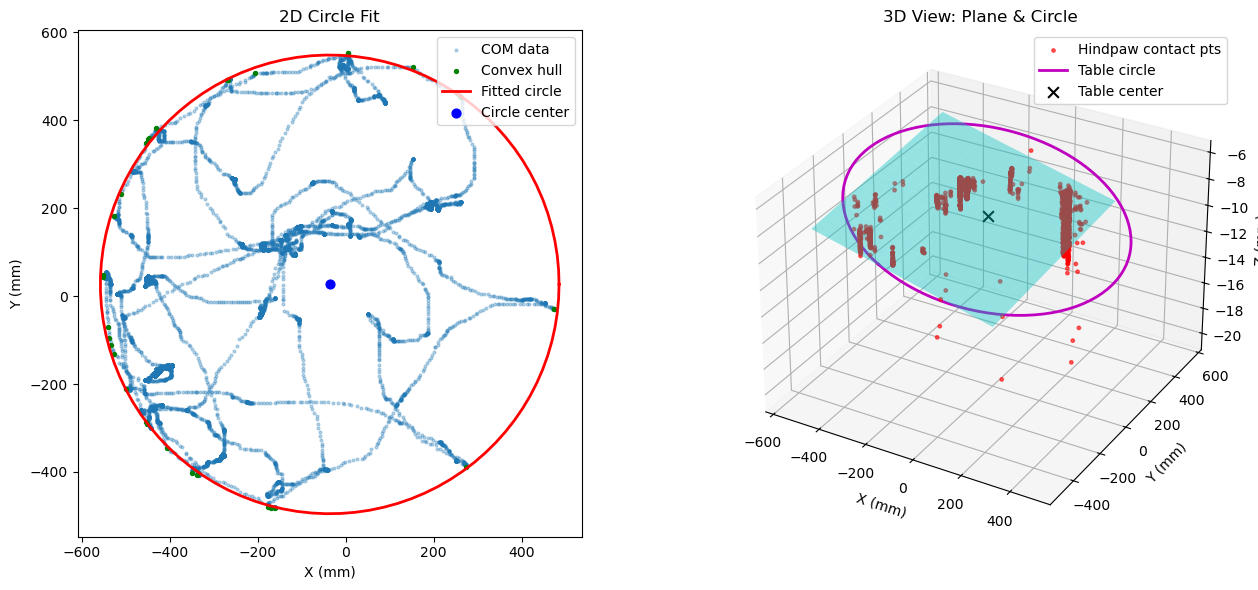

In [36]:
# ─── Cell 3: VISUALIZE FIT & PLANE ─────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# assume these are defined already in your notebook:
# x, y, hx, hy, xc, yc, r
# candidate_pts, centroid, normal, table_z

# parameterize circle in XY
theta    = np.linspace(0, 2*np.pi, 100)
circle_x = xc + r * np.cos(theta)
circle_y = yc + r * np.sin(theta)

# compute basis for table plane
def plane_basis(n):
    v  = np.array([1,0,0]) if abs(n[:2]).sum()<1e-6 else np.array([0,0,1])
    b1 = np.cross(n, v); b1 /= np.linalg.norm(b1)
    b2 = np.cross(n, b1); b2 /= np.linalg.norm(b2)
    return b1, b2

b1, b2     = plane_basis(normal)
table_ctr  = np.array([xc, yc, table_z])
circle3d   = np.array([table_ctr + r*(np.cos(t)*b1 + np.sin(t)*b2) for t in theta])

# plot
fig = plt.figure(figsize=(14,6))

# 2D XY view
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(x, y,        s=4, alpha=0.3, label='COM data')
ax1.scatter(hx, hy,      s=8, color='g', label='Convex hull')
ax1.plot(circle_x, circle_y, 'r-', lw=2, label='Fitted circle')
ax1.scatter(xc, yc,      color='b', s=40, label='Circle center')
ax1.set_aspect('equal')
ax1.set_xlabel('X (mm)')
ax1.set_ylabel('Y (mm)')
ax1.set_title('2D Circle Fit')
ax1.legend()

# 3D view
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(candidate_pts[:,0], candidate_pts[:,1], candidate_pts[:,2],
            color='r', s=6, alpha=0.6, label='Hindpaw contact pts')
# fitted plane
grid_x = np.linspace(candidate_pts[:,0].min(), candidate_pts[:,0].max(), 20)
grid_y = np.linspace(candidate_pts[:,1].min(), candidate_pts[:,1].max(), 20)
gx, gy = np.meshgrid(grid_x, grid_y)
gz     = (centroid[2]
          - (normal[0]*(gx-centroid[0]) + normal[1]*(gy-centroid[1]))
            / normal[2])
ax2.plot_surface(gx, gy, gz, alpha=0.4, color='cyan')
# circle on plane
ax2.plot(circle3d[:,0], circle3d[:,1], circle3d[:,2],
         'm-', lw=2, label='Table circle')
ax2.scatter(table_ctr[0], table_ctr[1], table_ctr[2],
            color='k', s=60, marker='x', label='Table center')
ax2.set_xlabel('X (mm)')
ax2.set_ylabel('Y (mm)')
ax2.set_zlabel('Z (mm)')
ax2.set_title('3D View: Plane & Circle')
ax2.legend()

plt.tight_layout()
plt.show()


In [37]:
# ─── Cell 3: ROBUST PLANE FIT WITH RANSAC ───────────────────────────────
import numpy as np
from sklearn.linear_model import RANSACRegressor, LinearRegression

# 1) stack both hindpaws
hp_idxs = [16, 19]
hp_pts  = np.vstack([pred[:, :, i] for i in hp_idxs])   # (2F,3)

# 2) build X (x,y) and y (z)
X = hp_pts[:, :2]   # columns [x, y]
y = hp_pts[:,  2]   # column  z

# 3) fit robust linear model z = a*x + b*y + c
ransac = RANSACRegressor(LinearRegression(), residual_threshold=1.0, random_state=0)
ransac.fit(X, y)
a, b    = ransac.estimator_.coef_
c       = ransac.estimator_.intercept_

# 4) derive plane normal
#    ax + by + c = z  →  a x + b y - 1·z + c = 0
normal = np.array([ a,  b, -1.0])
normal /= np.linalg.norm(normal)
if normal[2] < 0:
    normal = -normal

# 5) recompute table_z & tilt at (xc,yc)
table_z   = -(a*xc + b*yc + c)  # from z = a x + b y + c
tilt_rad  = np.arccos(np.clip(normal.dot([0,0,1]), -1,1))
tilt_deg  = np.degrees(tilt_rad)

print(f"RANSAC plane normal: {normal}")
print(f"Table Z @ center = {table_z:.2f} mm,  tilt = {tilt_deg:.2f}°")


RANSAC plane normal: [ 0.00712144 -0.00228153  0.99997204]
Table Z @ center = 6.12 mm,  tilt = 0.43°


Leveled plane normal: [-6.77996487e-15  2.17274115e-15  1.00000000e+00] → should be [0,0,1]


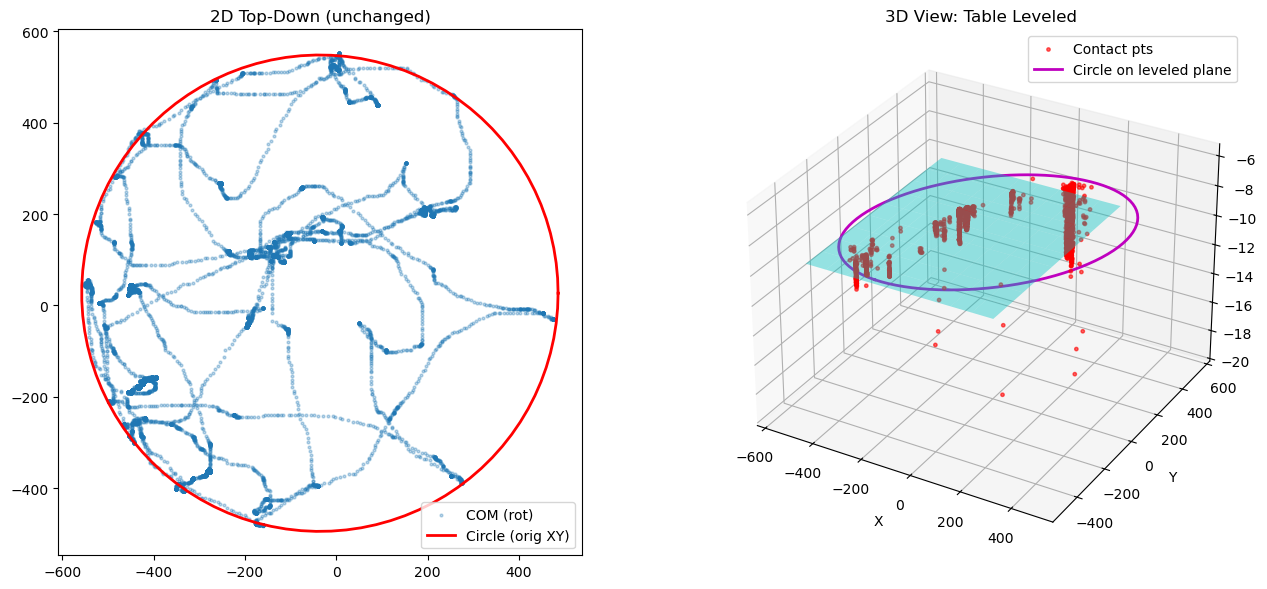

In [38]:
# ─── Cell 4: LEVEL THE TABLE PLANE ─────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# assume these are already defined:
#   normal       # your RANSAC plane normal (unit length)
#   com_data     # (M,3)
#   candidate_pts# (N,3)
#   circle3d     # (100,3)
#   xc, yc, r    # circle center & radius

# 1) compute rotation that sends `normal` → [0,0,1]
target = np.array([0.,0.,1.])
axis   = np.cross(normal, target)
ang    = np.arccos(np.clip(normal.dot(target), -1,1))
if np.linalg.norm(axis) < 1e-6:
    rot = R.from_rotvec([0,0,0])
else:
    rot = R.from_rotvec(axis/np.linalg.norm(axis) * ang)

# 2) apply to all your points
com_rot       = rot.apply(com_data)
cand_rot      = rot.apply(candidate_pts)
circle3d_rot  = rot.apply(circle3d)

# 3) quick check: new plane normal
new_norm = rot.apply(normal)
print("Leveled plane normal:", new_norm, "→ should be [0,0,1]")

# 4) re‑plot in two panels
theta = np.linspace(0,2*np.pi,100)

fig = plt.figure(figsize=(14,6))

# 2D XY (should look identical)
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(com_rot[:,0], com_rot[:,1], s=4, alpha=0.3, label='COM (rot)')
ax1.plot(xc + r*np.cos(theta), yc + r*np.sin(theta), 'r-', lw=2, label='Circle (orig XY)')
ax1.set_aspect('equal'); ax1.set_title('2D Top‑Down (unchanged)'); ax1.legend()

# 3D view (table now horizontal)
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.scatter(cand_rot[:,0], cand_rot[:,1], cand_rot[:,2], color='r', s=6, alpha=0.6, label='Contact pts')
# plane (should be z≈constant)
z0 = cand_rot[:,2].mean()
xx = np.linspace(cand_rot[:,0].min(), cand_rot[:,0].max(), 10)
yy = np.linspace(cand_rot[:,1].min(), cand_rot[:,1].max(), 10)
XX,YY = np.meshgrid(xx,yy)
ZZ = np.ones_like(XX)*z0
ax2.plot_surface(XX,YY,ZZ, alpha=0.4, color='cyan')
# circle
ax2.plot(circle3d_rot[:,0], circle3d_rot[:,1], circle3d_rot[:,2],
         'm-', lw=2, label='Circle on leveled plane')
ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')
ax2.set_title('3D View: Table Leveled'); ax2.legend()

plt.tight_layout()
plt.show()
